# Import required package

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from PIL import Image

from sklearn.neighbors import KernelDensity

import matplotlib.pyplot as plt

# Load input and define output directory

In [2]:
OUTPUT_DIR = "output/"  # Folder to save processed results

# Input image paths (original and YOLO+RCNN masked versions)
OrgImg_dir = 'original/frame528.jpg'
MaskedImg_dir = 'masked_inputs/combined_frame528.jpg'

# GMM thresholding

In [3]:
# Read and prepare the image
image_bgr = cv2.imread(MaskedImg_dir)

# Convert BGR → RGB
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)            # type: ignore
h, w = image_rgb.shape[:2]


# Define brightness threshold for smoke-like regions
THRESH_MIN = 130
THRESH_MAX = 255

# Initialize mask and storage for filtered pixels
filtered_pixels = []
mask = np.zeros((h, w), dtype=np.uint8)

# Create mask for bright (smoke-like) pixels
for y in range(h):
    for x in range(w):
        R, G, B = image_rgb[y, x]
        if (THRESH_MIN <= R <= THRESH_MAX and
            THRESH_MIN <= G <= THRESH_MAX and
            THRESH_MIN <= B <= THRESH_MAX):
            filtered_pixels.append([x, y, R, G, B])
            mask[y, x] = 255  # Mark as bright pixel

# Highlight thresholded regions in red
highlighted = image_bgr.copy()                                    # type: ignore
highlighted[mask == 255] = [0, 0, 255]

## Save and display results

 Filtered pixel data saved: output/filtered_pixels_combined.csv
 Highlighted image saved: output/filtered_highlighted.jpg


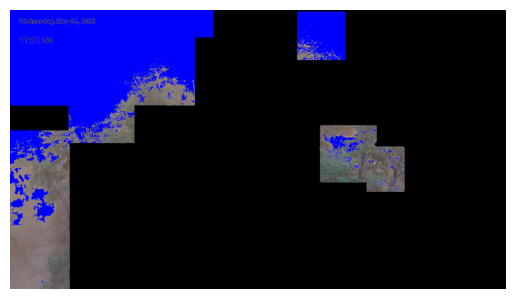

In [4]:
# Define output file paths
FILTERED_CSV = os.path.join(OUTPUT_DIR, "filtered_pixels_combined.csv")
FILTERED_IMAGE = os.path.join(OUTPUT_DIR, "filtered_highlighted.jpg")

# Save filtered pixel data
if filtered_pixels:
    df = pd.DataFrame(filtered_pixels, columns=["x", "y", "R", "G", "B"])
    df.to_csv(FILTERED_CSV, index=False)
    print(f" Filtered pixel data saved: {FILTERED_CSV}")
else:
    print("No bright pixels found in the given range.")
    df = pd.DataFrame(columns=["x", "y", "R", "G", "B"])

# Save highlighted image
cv2.imwrite(FILTERED_IMAGE, highlighted)
print(f" Highlighted image saved: {FILTERED_IMAGE}")

# Display highlighted image
plt.imshow(highlighted)
plt.axis('off')
plt.show()

#  KDE Computation

In [5]:
# Load original image and read filtered data
orig_image = Image.open(OrgImg_dir).convert("RGB")
orig_np = np.array(orig_image)
img_width, img_height = orig_image.size
print(img_width, img_height)

# Load filtered pixel coordinates
df = pd.read_csv(FILTERED_CSV)
# Extract pixel coordinates from the CSV
X = df[["x", "y"]].values

# Build evaluation grid
xgrid = np.linspace(0, img_width, 150)
ygrid = np.linspace(0, img_height, 150)
X_grid, Y_grid = np.meshgrid(xgrid, ygrid)
xy_grid = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T

# Estimate density using 2D KDE
kde = KernelDensity(kernel="gaussian", bandwidth = 15,
                    algorithm='ball_tree',  # much faster for large data
                    atol=1e-8, rtol=1e-8,   # loose tolerances → faster
                    leaf_size=50,          # adjust tree granularity
    ).fit(X)
log_dens = kde.score_samples(xy_grid)
dens = np.exp(log_dens).reshape(X_grid.shape)

# Compute 95th percentile contour level
quantile_95 = np.quantile(dens, 0.95)

1920 1080


## Visualize and save KDE results

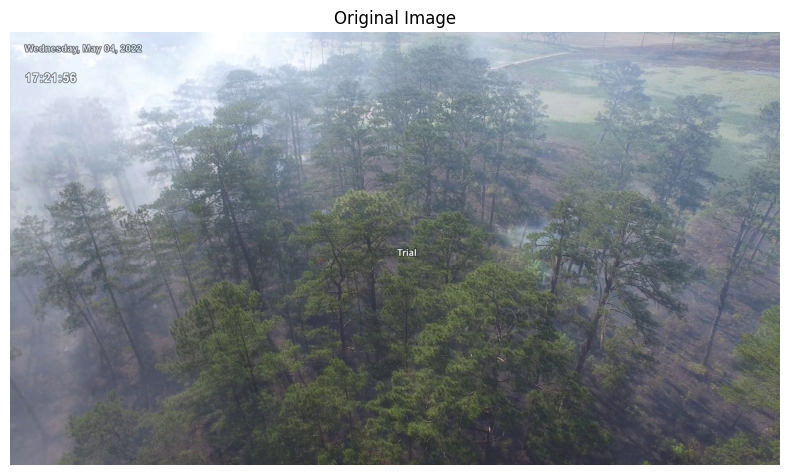

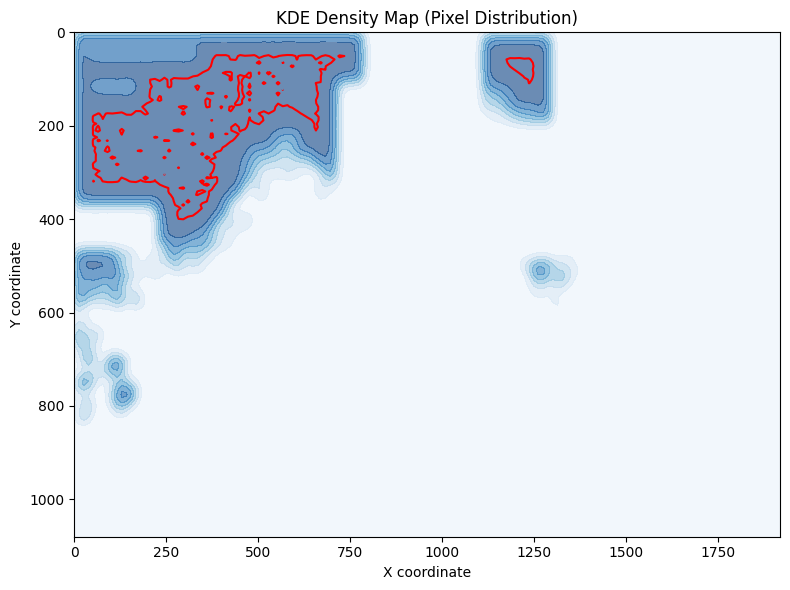

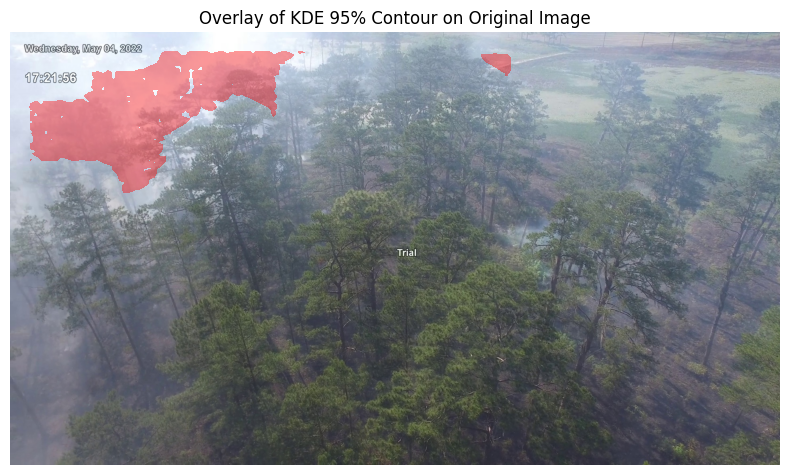

In [6]:
# Define output paths
KDE_PLOT = os.path.join(OUTPUT_DIR, "kde_plot.png")
OVERLAY_PLOT = os.path.join(OUTPUT_DIR, "overlay_plot.png")

# Show original image 
fig0, ax0 = plt.subplots(figsize=(8, 6))
ax0.imshow(orig_np)
ax0.set_title("Original Image")
ax0.axis("off")
fig0.tight_layout()
plt.show()

# Plot KDE heatmap (on blank background)
fig1, ax1 = plt.subplots(figsize=(8, 6))
ax1.contourf(X_grid, Y_grid, dens, cmap="Blues", alpha=0.6)
ax1.contour(X_grid, Y_grid, dens, levels=[quantile_95], colors="red")
ax1.set_title("KDE Density Map (Pixel Distribution)")
ax1.set_xlabel("X coordinate")
ax1.set_ylabel("Y coordinate")
ax1.invert_yaxis()
fig1.tight_layout()
fig1.savefig(KDE_PLOT, dpi=200, bbox_inches="tight")
plt.show()

# Overlay KDE contour on original image
fig2, ax2 = plt.subplots(figsize=(8, 6))
ax2.imshow(orig_np, extent=[0, img_width, 0, img_height])          # type:ignore
ax2.contourf(
    X_grid,
    Y_grid[::-1],
    dens,
    levels=[quantile_95, dens.max()],
    colors="red",
    alpha=0.4,
)
ax2.set_title("Overlay of KDE 95% Contour on Original Image")
ax2.axis("off")
fig2.tight_layout()
fig2.savefig(OVERLAY_PLOT, dpi=200, bbox_inches="tight")
plt.show()